In [19]:
from qutip import Qobj, basis, expect, ket2dm, mesolve, qeye, sigmax, sigmaz, tensor
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt

np.set_printoptions(formatter={"all": lambda x: "{:.4g}".format(x)})


#   Tensor product such that i-th element is sigma_x and rest are identity
def tensor_sigmax(i: int, n: int) -> Qobj:
    ops = [qeye(2) for _ in range(n)]
    ops[i] = sigmax()
    return tensor(ops)


#   Tensor product such that i-th element is (I - sigma_z) / 2 and rest are identity
def tensor_sigmaz(i: int, n: int) -> Qobj:
    ops = [qeye(2) for _ in range(n)]
    ops[i] = (qeye(2) - sigmaz()) / 2
    return tensor(ops)


def sim(profits, weights, capacity, alpha: float) -> list:
    #   Derived parameters
    num_items = profits.shape[0]
    M = int(np.floor(np.log2(capacity)))

    total_qubits = num_items + M + 1
    num_states = np.power(2, total_qubits)

    #   Initial Hamiltonian H_0
    H_0 = -sum(tensor_sigmax(i, total_qubits) for i in range(total_qubits))

    H_A1 = sum(
        np.power(2, j - num_items) * tensor_sigmaz(j, total_qubits)
        for j in range(num_items, num_items + M)
    )  #   starting from the 1st ancillary qubit

    H_A2 = (capacity + 1 - np.power(2, M)) * tensor_sigmaz(num_items + M, total_qubits)

    H_A3 = -sum(weights[i] * tensor_sigmaz(i, total_qubits) for i in range(num_items))

    H_A = (H_A1 + H_A2 + H_A3) ** 2

    H_B = -sum(profits[i] * tensor_sigmaz(i, total_qubits) for i in range(num_items))

    H_P = alpha * H_A + H_B

    ground_eigenvalue, ground_eigenstates = H_0.groundstate()
    psi0 = ground_eigenstates

    times = np.linspace(0, 1, 100000)

    #   Time-dependent Hamiltonian function
    def H(s):
        return (1 - s) * H_0 + s * H_P

    result = mesolve(H, psi0, times, e_ops=[])

    def generate_basis_states(n):
        """Generates a list of all basis states for n qubits."""
        return [
            tensor([basis(2, (i >> m) % 2) for m in range(n - 1, -1, -1)])
            for i in range(num_states)
        ]

    basis_states = generate_basis_states(total_qubits)
    basis_matrix = np.hstack([basis_state.full() for basis_state in basis_states])

    state_matrix = np.hstack([psi.full() for psi in result.states])

    probabilities = np.power(
        np.abs(np.dot(basis_matrix.T.conj(), state_matrix)), 2
    ).T.tolist()

    final_probabilities = [
        (format(idx, f"0{total_qubits}b"), prob)
        for idx, prob in enumerate(probabilities[-1])
    ]

    valid_state_labels = ["1010", "1001"]
    return [
        (state_label, prob)
        for state_label, prob in final_probabilities
        if state_label in valid_state_labels
    ]


#   Parameters to set
profits = np.array([10, 2])
weights = np.array([1, 2])
capacity = 2


def get_total_probability(res):
    return sum(prob for _, prob in res)


alphas = np.linspace(profits.shape[0] + 1, profits.shape[0] + 100, 500)
probs = [
    get_total_probability(sim(profits, weights, capacity, alpha)) for alpha in alphas
]

0.27219126331307664


Text(0.5, 1.0, 'Solution probability against alpha parameter')

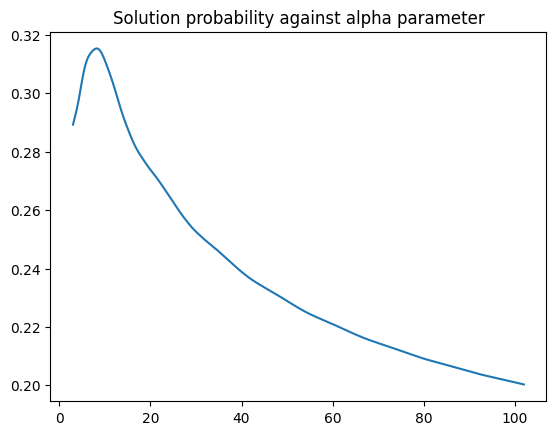

In [20]:
fig, ax = plt.subplots()
ax.plot(alphas, probs)
ax.set_title('Solution probability against alpha parameter')